# Redes neuronales en un problema de regresión

En este notebook vamos a estudiar cómo utilizar una red neuronal de tipo perceptrón multicapa en un problema de regresión.

In [1]:
RANDOM_STATE=333

## Conjunto de datos

En este caso vamos a trabajar con un conjunto de datos que describe el precio de las casas en Bostón en función de un conjunto de variables que describen sus características (1980):

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

In [2]:
from sklearn.datasets import load_boston

boston = load_boston()

In [3]:
import pandas as pd

df = pd.DataFrame(data=boston['data'], columns=boston['feature_names']) 
df['target'] = boston['target']

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


En este dataset no tenemos demasiadas variables. Si hubiera demasiadas variables podríamos seleccionar las que estén más correladas con la variable target.

In [5]:
# buscamos las variables más correladas con la variable a predecir (target)
correl=df.corr()
correl['target']

# para mostrar sólo las que superen cierto umbral de correlación
#correl[abs(correl['target']) > 0.5]['target']

CRIM      -0.388305
ZN         0.360445
INDUS     -0.483725
CHAS       0.175260
NOX       -0.427321
RM         0.695360
AGE       -0.376955
DIS        0.249929
RAD       -0.381626
TAX       -0.468536
PTRATIO   -0.507787
B          0.333461
LSTAT     -0.737663
target     1.000000
Name: target, dtype: float64

<AxesSubplot:>

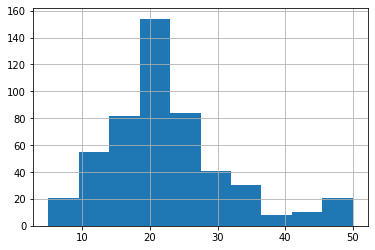

In [6]:
df.target.hist()

Observamos una distribución asimétrica a la derecha y con un número de observaciones anormalmente alto en la última barra.

## Reescalado de los datos

Cuando trabajamos con redes neuronales suele ser una buena idea reescalar los datos para facilitar que el entrenamiento converja más rápidamente.

In [7]:
from sklearn.preprocessing import StandardScaler

# Transformamos las variables de entrada
scaler_x = StandardScaler()
scaler_x.fit(boston.data)
boston_scaled=scaler_x.transform(boston.data)

# Y también transformamos la variable de salida
scaler_y = StandardScaler()
scaler_y.fit(boston.target.reshape(-1, 1)) # Como es una sola variable es necesario ponerlo en modo columna
target_scaled=scaler_y.transform(boston.target.reshape(-1, 1))

## Buscamos el mejor coeficiente de regularización usando validación cruzada

De todos los parámetros que podemos configurar en la red neuronal (capas, neuronas, funciones de activación, regulación, tasa de aprendizaje, ...) nosotros sólo vamos optimizar el coeficiente de regularización.

Nosotros vamos a utilizar una red con una capa oculta con 100 neuronas, función de activación ReLU, regularización L2, tamaño de mini-batch 100, tasa de aprendizaje 0.1, y máximo de 500 iteraciones a los datos (epochs).

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

cv_scores_mean=[]
cv_scores_std=[]

# Entrenar y validar distintas configuraciones
regul_param_range = 10.0 ** -np.arange(1, 7) # [0.1, 0.01, ..., 0.0000001]
for regul_param in regul_param_range:
    # Aumentamos el parámetro max_iter hasta que converja
    mlp=MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=regul_param, batch_size=100, 
             learning_rate='constant', learning_rate_init=0.001, max_iter=500, random_state=RANDOM_STATE)
    
    # El error es neg_mean_squared_error el MSE en negativo!! Más pequeño peor.
    scores = cross_val_score(mlp, boston_scaled, target_scaled.ravel(), cv=5, scoring='neg_mean_squared_error')
    
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())

cv_scores_mean, cv_scores_std

([-0.256329653316279,
  -0.2929546675076595,
  -0.28898379140049124,
  -0.2879938723741414,
  -0.28850257904226023,
  -0.28916815821507785],
 [0.16143352836399805,
  0.17742455783646174,
  0.1633031881189968,
  0.16383232451797383,
  0.16366138662735946,
  0.1642382826333366])

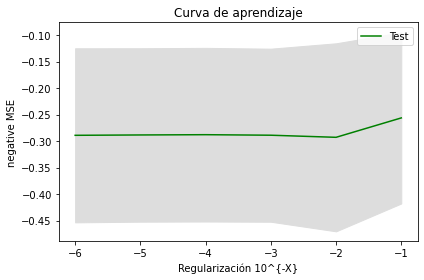

In [9]:
import matplotlib.pyplot as plt

# Dibujamos la línea de la exactitud media en las partes de test
plt.plot(np.log10(regul_param_range), cv_scores_mean, color="g", label="Test")

# Dibujamos la banda de la desviación típica
lower_limit = np.array(cv_scores_mean) - np.array(cv_scores_std)
upper_limit = np.array(cv_scores_mean) + np.array(cv_scores_std)
plt.fill_between(np.log10(regul_param_range), lower_limit, upper_limit, color="#DDDDDD")

# Creamos el gráfico
plt.title("Curva de aprendizaje")
plt.xlabel("Regularización 10^{-X}"), plt.ylabel("negative MSE"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Podemos obsevar un comportamiento bastante estable para este parámetro. Parece que el mejor valor (el más cercano a cero) es con $\alpha=10^{-3}$.

## Análisis del error

Vamos a estudiar con un poco más de detalle la distribución de los errores. Para hacerlo vamos a obtener predicciones de los precios de todas las casas usando validación cruzada con la función `cross_val_predict`.

In [10]:
from sklearn.model_selection import cross_val_predict

# Creamos el clasificador
regul_param=0.1
mlp = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=regul_param, batch_size=100, 
             learning_rate='constant', learning_rate_init=0.001, max_iter=500, random_state=RANDOM_STATE)
    
# estimamos 
predicts_scaled = cross_val_predict(mlp, boston_scaled, target_scaled.ravel(), cv=10)

# desescalamos las predicciones para que estén en la escala original
predicts=scaler_y.inverse_transform(predicts_scaled)

In [11]:
errors = np.abs(boston.target - predicts) # error en cada ejemplo
mean_error = np.mean(errors)
std_error = np.std(errors)
mean_price = np.mean(boston['target'])

print('Error medio:', mean_error)
print('Desviación típica:', std_error)
print('Error medio en %:', mean_error/mean_price*100)

Error medio: 3.312845980154531
Desviación típica: 3.4172781238609176
Error medio en %: 14.702323059554734


Nuestro modelo comete un error medio de 3312$ con una desviación típica muy grande. Seguramente un error medio del 14.7\% no es muy buen resultado.

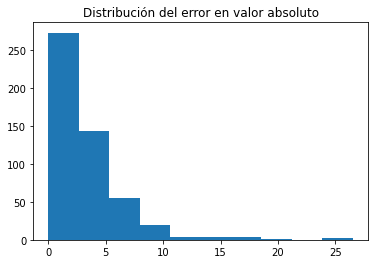

In [12]:
# Dibujamos el histograma de los errores
fig1 = plt.figure()
ax1 = plt.axes()
ax1.hist(errors)

plt.title('Distribución del error en valor absoluto')
plt.show()

Aunque la mayor parte de los errores se concentran en la parte izquierda de la gráfica, también hay algunos errores demasiado elevados que no son deseables.

Vamos a dibujar la distancia entre el valor predicho por el modelo y el valor real en una gráfica. La diagonal representa error 0.

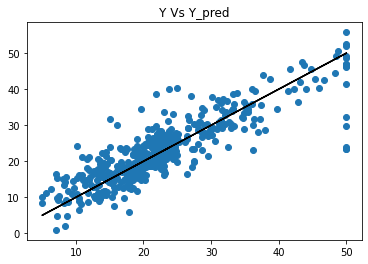

In [13]:
fig2 = plt.figure()
ax2 = plt.axes()

# dibujamos los errores: la distancia a la recta indica el nivel de error
ax2.scatter(boston.target, predicts) 
# Pintamos la referencia de la predicción perfecta
ax2.plot(boston.target, boston.target, color='k') 

plt.title('Y Vs Y_pred')
plt.show()

Al pintar el gráfico vemos que la mayor desviación se produce para los valores de Y=50.

Esto seguramente quiere decir que se pueda mejorar la estimación y que hay que hacer algo con los valores superiores del rango.